# Interpret regression models using Boston House Prices Dataset

This notebook demonstrates how to apply `Captum` library on a regression model and understand important features, layers / neurons that contribute to the prediction. It compares a number of attribution algorithms from `Captum` library for a simple DNN model trained on a sub-sample of a well-known Boston house prices dataset.

Note that in order to be able to run this notebook successfully you need to install scikit-learn package in advance.


In [1]:
import numpy as np

from os import path


import matplotlib.pyplot as plt

#scikit-learn related imports
import sklearn
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim

# imports from captum library
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation


## Data loading and pre-processing

Let's load boston house prices dataset and corresponding labels from scikit-learn library. 

In [2]:
boston = load_boston()

# feature_names -> ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
feature_names = boston.feature_names

X = boston.data
y = boston.target


In order to retain deterministic results, let's fix the seeds.

In [3]:
torch.manual_seed(1234)
np.random.seed(1234)


Let's use 70% of our data for training and the remaining 30% for testing.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


# Data Exploration

Let's visualize dependent variable vs each independent variable in a separate plot. Apart from that we will also perform a simple regression analysis and plot the fitted line in dashed, red color.

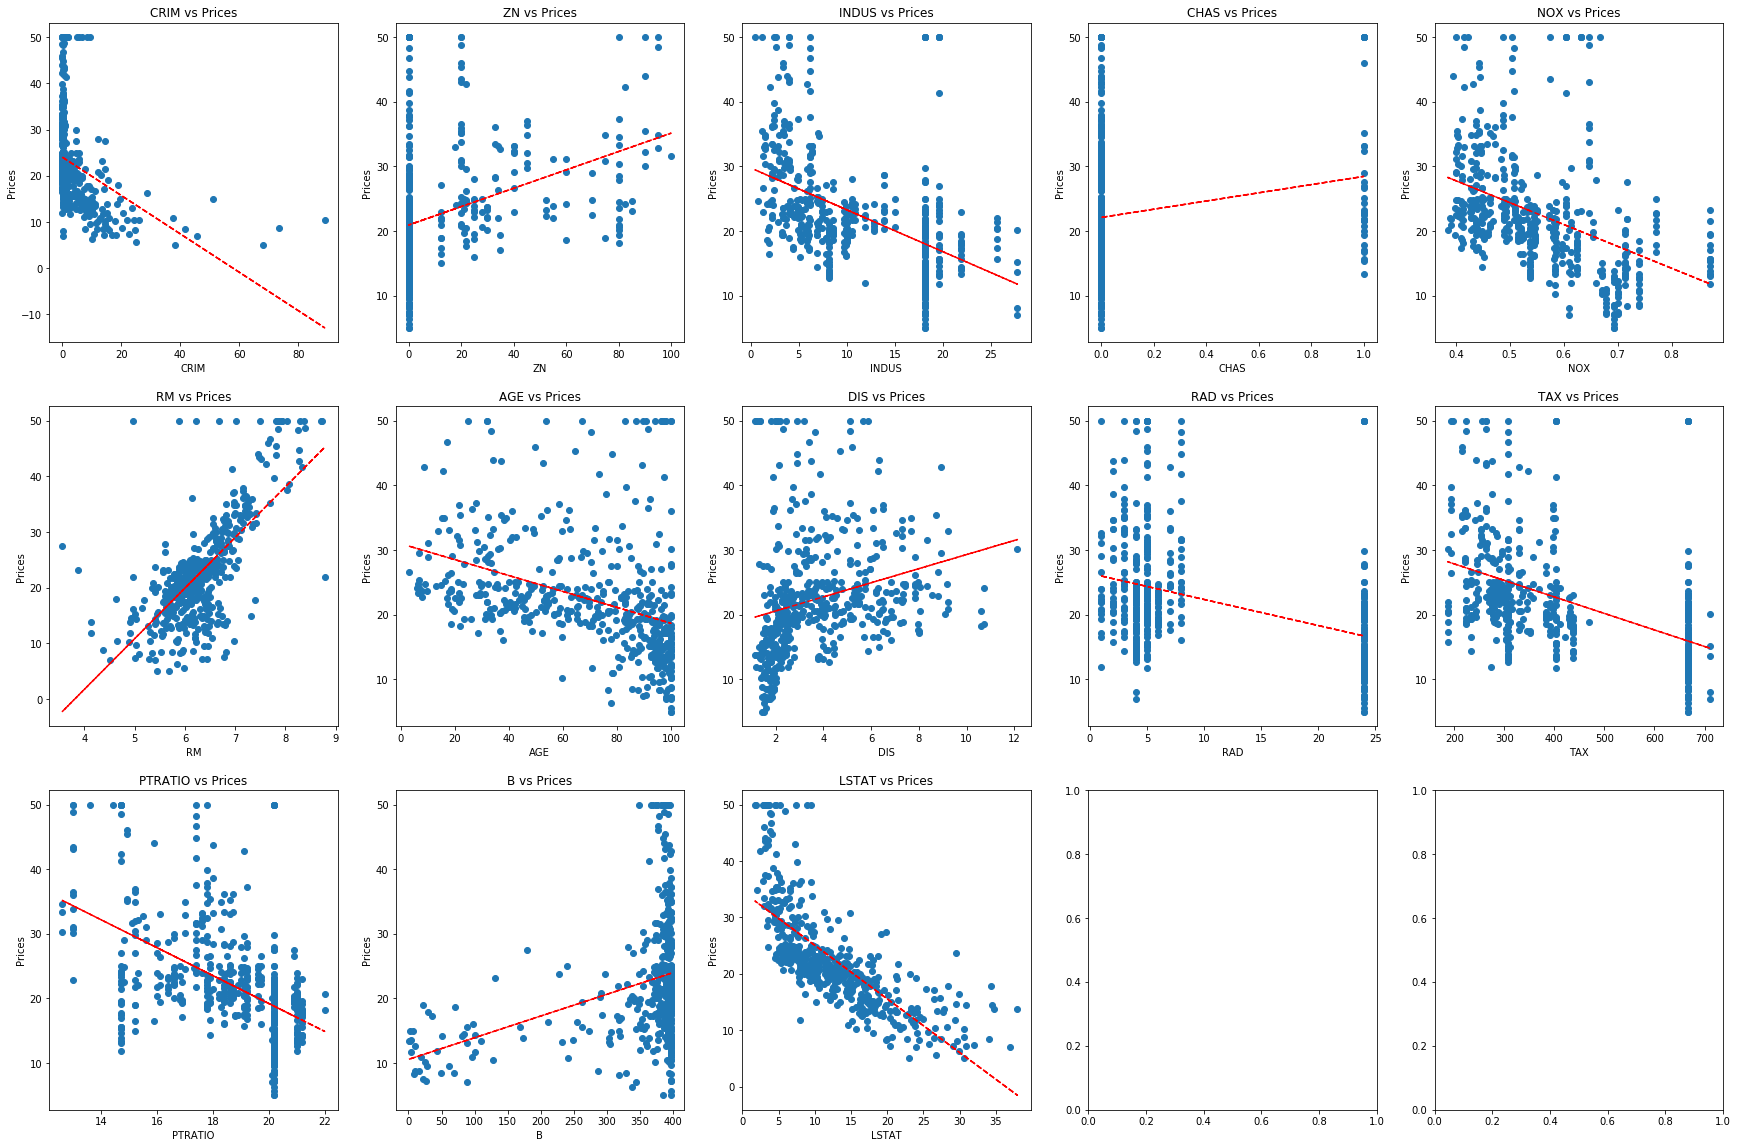

In [5]:
fig, axs = plt.subplots(nrows = 3, ncols=5, figsize=(30, 20))
for i, (ax, col) in enumerate(zip(axs.flat, feature_names)):
    x = X[:,i]
    pf = np.polyfit(x, y, 1)
    p = np.poly1d(pf)

    ax.plot(x, y, 'o')
    ax.plot(x, p(x),"r--")

    ax.set_title(col + ' vs Prices')
    ax.set_xlabel(col)
    ax.set_ylabel('Prices')


From the diagram above we can tell that some of the most influential features that are correlated with the output price are:   
   - RM, the average numbers of rooms in the houses of the neighborhood.
     If RM increases the house price increases too.
   - LSTAT, the percentage of the house-owners in the neighborhood (lower class).
     This variable is negatively correlated with the price. The lower the class the less likely is that the person will be able to afford an expensive house.
   - PTRATIO, the pupil-teacher ratio by town.
     If the pupil-teacher ratio increases then the house price decreases, resulting in a negative correlation between ptratio and house price.
     
These features are being identified as important also from others and can be found by an online search.

# Tensorizing inputs and creating batches

Below we tensorize input features and corresponding labels.


In [6]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)


Defining default hyper parameters for the model.


In [7]:
batch_size = 50
num_epochs = 200
learning_rate = 0.0001
size_hidden1 = 100
size_hidden2 = 50
size_hidden3 = 10
size_hidden4 = 1

We define a four layer neural network containing ReLUs between each linear layer. This network is slightly more complex than the standard linear regression model and results in a slightly better accuracy.

In [8]:
class BostonModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(13, size_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(size_hidden2, size_hidden3)
        self.relu3 = nn.ReLU()
        self.lin4 = nn.Linear(size_hidden3, size_hidden4)

    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))


In [9]:
model = BostonModel()
model.train()


BostonModel(
  (lin1): Linear(in_features=13, out_features=100, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=50, out_features=10, bias=True)
  (relu3): ReLU()
  (lin4): Linear(in_features=10, out_features=1, bias=True)
)

## Train Boston Model

Defining the loss function that will be used for optimization.

In [10]:
criterion = nn.MSELoss(reduction='sum')

Defining the training function that contains the training loop and uses RMSprop and given input hyper-parameters to train the model defined in the cell above.

In [11]:
def train(model_inp, num_epochs = num_epochs):
    optimizer = torch.optim.RMSprop(model_inp.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in train_iter:
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0


If the model was previously trained and stored, we load that pre-trained model, otherwise, we train a new model and store it for future uses.

Models can found here: https://github.com/pytorch/captum/tree/master/tutorials/models

In [12]:
def train_load_save_model(model_obj, model_path):
    if path.isfile(model_path):
        # load model
        print('Loading pre-trained model from: {}'.format(model_path))
        model_obj.load_state_dict(torch.load(model_path))
    else:    
        # train model
        train(model_obj)
        print('Finished training the model. Saving the model to the path: {}'.format(model_path))
        torch.save(model_obj.state_dict(), model_path)

In [13]:
SAVED_MODEL_PATH = 'models/boston_model.pt'
train_load_save_model(model, SAVED_MODEL_PATH)

Loading pre-trained model from: models/boston_model.pt


Let's perform a simple sanity check and compute the performance of the model using Root Squared Mean Error (RSME) metric.

In [14]:
model.eval()
outputs = model(X_test)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy()))

print('model err: ', err)

model err:  5.0695343


# Comparing different attribution algorithms

Let's compute the attributions with respect to the inputs of the model using different attribution algorithms from core `Captum` library and visualize those attributions. We use test dataset defined in the cells above for this purpose.

We use mainly default settings, such as default baselines, number of steps etc., for all algorithms, however you are welcome to play with the settings. For GradientSHAP specifically we use the entire training dataset as the distribution of baselines.

Note: Please, be patient! The execution of the cell below takes half a minute.

In [ ]:
ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

ig_attr_test = ig.attribute(X_test, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(X_test)
dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

Now let's visualize attribution scores with respect to inputs (using test dataset) for our simple model in one plot. This will help us to understand how similar or different the attribution scores assigned from different attribution algorithms are. Apart from that we will also compare attribution scores with the learned model weights.

It is important to note the we aggregate the attributions across the entire test dataset in order to retain a global view of feature importance. This, however, is not ideal since the attributions can cancel out each other when we aggregate then across multiple samples.

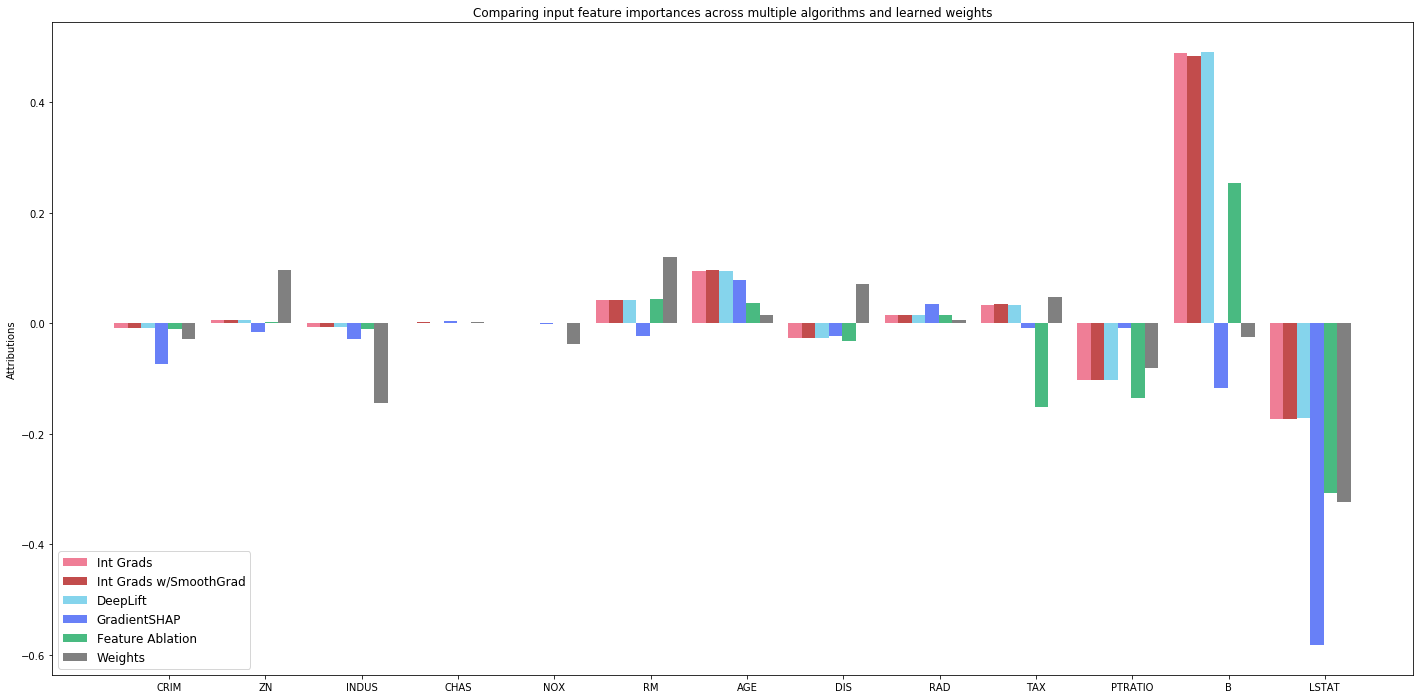

In [16]:
# prepare attributions for visualization

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = model.lin1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()


The magnitudes of learned model weights tell us about the correlations between the dependent variable `Price` and each independent variable. Zero weight means no correlation whereas positive weights indicate positive correlations and negatives the opposite. Since the network has more than one layer these weights might not be directly correlated with the price.

From the plot above we can see that attribution algorithms sometimes disagree on assigning importance scores and that they are not always aligned with weights. However, we can still observe that the top important three features: `LSTAT`, `RM` and `PTRATIO` are also considered to be important based on both most attribution algorithms and the weight scores.

It is interesting to observe that the feature `B` has high positive attribution score based on some of the attribution algorithms. This can be related, for example, to the choice of the baseline. In this tutorial we use zero-valued baselines for all features, however if we were to choose those values more carefully for each feature the picture will change. Similar arguments apply also when the signs of the weights and attributions mismatches or when one algorithm assigns higher or lower attribution scores compare to the others.

In terms of least important features, we observe that `CHAS` and `RAD` are voted to be least important both based on most attribution algorithms and learned coefficients.

Another interesting observation is that both Integrated Gradients and DeepLift return similar attribution scores across all features. This is associated with the fact that although we have non-linearities in our model, their effects aren't significant and DeepLift is close to `(input - baselines) * gradients`. And because the gradients do not change significantly along the straight line from baseline to input, we observe similar situation with Integrated Gradients as well.

## Attributing to the layers and comparing with model weights

Now let's beside attributing to the inputs of the model, also attribute to the layers of the model and understand which neurons appear to be more important.

In the cell below we will attribute to the inputs of the second linear layer of our model. Similar to the previous case, the attribution is performed on the test dataset.

In [17]:
# Compute the attributions of the output with respect to the inputs of the fourth linear layer
lc = LayerConductance(model, model.lin4)
lc_attr_test = lc.attribute(X_test, n_steps=100, attribute_to_layer_input=True)

# shape: test_examples x size_hidden
lc_attr_test = lc_attr_test[0]

# weights from forth linear layer
# shape: size_hidden4 x size_hidden3
lin4_weight = model.lin4.weight

In the cell below we normalize and visualize the attributions and learned model weights for all 10 neurons in the fourth hidden layer. 
The weights represent the weight matrix of the fourth linear layer. The attributions are computed with respect to the inputs of the fourth linear layer.

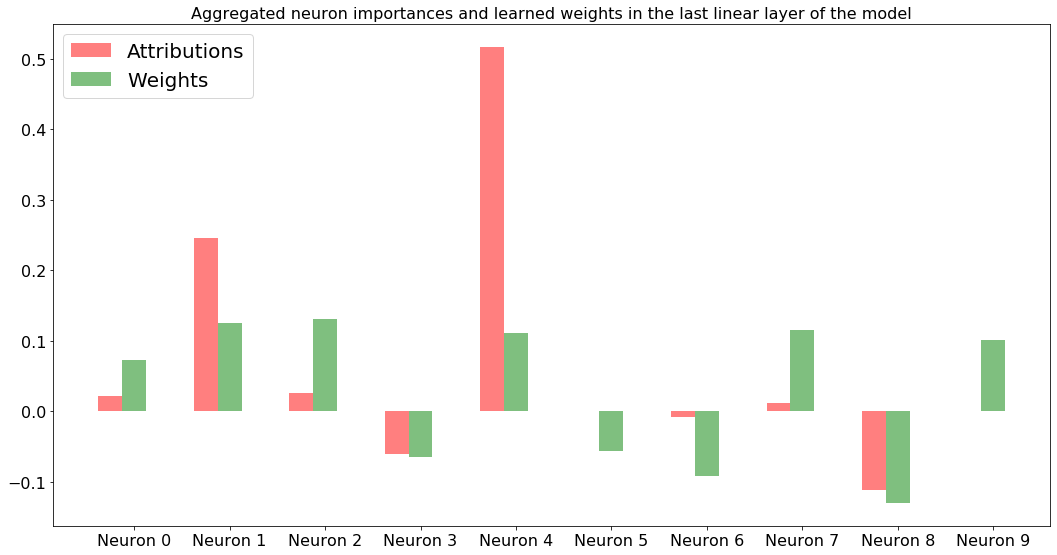

In [18]:
plt.figure(figsize=(15, 8))

x_axis_data = np.arange(lc_attr_test.shape[1])

y_axis_lc_attr_test = lc_attr_test.mean(0).detach().numpy()
y_axis_lc_attr_test = y_axis_lc_attr_test / np.linalg.norm(y_axis_lc_attr_test, ord=1)

y_axis_lin4_weight = lin4_weight[0].detach().numpy()
y_axis_lin4_weight = y_axis_lin4_weight / np.linalg.norm(y_axis_lin4_weight, ord=1)

width = 0.25
legends = ['Attributions','Weights']
x_axis_labels = [ 'Neuron {}'.format(i) for i in range(len(y_axis_lin4_weight))]

ax = plt.subplot()
ax.set_title('Aggregated neuron importances and learned weights in the last linear layer of the model')

ax.bar(x_axis_data + width, y_axis_lc_attr_test, width, align='center', alpha=0.5, color='red')
ax.bar(x_axis_data + 2 * width, y_axis_lin4_weight, width, align='center', alpha=0.5, color='green')
plt.legend(legends, loc=2, prop={'size': 20})
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_labels)

plt.show()


It is interesting to observe that the weights and attribution scores are well aligned for all 10 neurons in the last layer. Meaning that the neurons with negative weights also have negative attribution scores and we can observe the same for the positive weights and attributions. 

We also observe that the neurons five and nine have very small attributions but relatively larger weights. Another interesting thing to observe is that the weights do not fluctuate much whereas attributions do fluctuate more relative to that and spike in Layer 4.